In [64]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load fits 
def load_fits(filename):
    with fits.open(filename) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

# Identify peak pixels 
def find_peaks(image, threshold, target=(300, 300), radius=10):
    peaks = []
    target_x, target_y = target
    for i in range(max(1, target_x - radius), min(image.shape[0] - 1, target_x + radius)):
        for j in range(max(1, target_y - radius), min(image.shape[1] - 1, target_y + radius)):
            if (image[i, j] > threshold and
                image[i, j] > image[i+1, j] and
                image[i, j] > image[i-1, j] and
                image[i, j] > image[i, j+1] and
                image[i, j] > image[i, j-1]):
                peaks.append((i, j))
    return np.array(peaks)

# Plot the fits 
def plot_fits_image(data, vmin=0, vmax=5000, title="FITS Image"):
    plt.imshow(data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot peaks
def plot_peaks(image, peaks, threshold):
    plot_fits_image(image, vmax=threshold, title=f"Peaks within threshold {threshold}")
    plt.scatter(peaks[:, 1], peaks[:, 0], edgecolors='red', facecolors='none', s=50, label='Peaks')
    plt.legend()
    plt.show()

# Plot centroids 
def plot_centroid(image, peaks, centroids, threshold):
    plot_fits_image(image, vmax=threshold, title="Centroids with Peaks Overlay")
    plt.scatter(peaks[:, 1], peaks[:, 0], edgecolors='red', facecolors='none', s=50, label='Peaks')
    plt.scatter([c[1] for c in centroids], [c[0] for c in centroids], color='blue', marker='x', s=50, label='Centroids')
    plt.legend()
    plt.show()

# Find centroid of a peak within window
def find_centroid(image, guess_x, guess_y, window=5):
    x_min = max(0, guess_x - window // 2)
    x_max = min(image.shape[0], guess_x + window // 2 + 1)
    y_min = max(0, guess_y - window // 2)
    y_max = min(image.shape[1], guess_y + window // 2 + 1)
    window_data = image[x_min:x_max, y_min:y_max]
    
    x = np.arange(x_min, x_max)
    y = np.arange(y_min, y_max)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    total_flux = np.sum(window_data)
    centroid_x = np.sum(X * window_data) / total_flux
    centroid_y = np.sum(Y * window_data) / total_flux
    
    return centroid_x, centroid_y

# Calculate PSF 
def find_moment(image, centroid_x, centroid_y, window=5):
    x_min = int(centroid_x - window // 2)
    x_max = int(centroid_x + window // 2) + 1
    y_min = int(centroid_y - window // 2)
    y_max = int(centroid_y + window // 2) + 1
    
    window_data = image[x_min:x_max, y_min:y_max]
    X, Y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max), indexing='ij')
    
    total_flux = np.sum(window_data)
    sigma_x = np.sqrt(np.sum((X - centroid_x)**2 * window_data) / total_flux)
    sigma_y = np.sqrt(np.sum((Y - centroid_y)**2 * window_data) / total_flux)
    
    return sigma_x, sigma_y

# Background calculation around peak
def calculate_background(image, x, y, window=10):
    x_min = max(0, x - window)
    x_max = min(image.shape[0], x + window + 1)
    y_min = max(0, y - window)
    y_max = min(image.shape[1], y + window + 1)
    
    background_region = image[x_min:x_max, y_min:y_max]
    return np.median(background_region)

# Determine best aperture
def calculate_signal_to_noise(image, centroid_x, centroid_y, sigma_x, sigma_y, aperture=120):
    # Define the aperture bounds around centroid
    x_min = int(centroid_x - aperture // 2)
    x_max = int(centroid_x + aperture // 2) + 1
    y_min = int(centroid_y - aperture // 2)
    y_max = int(centroid_y + aperture // 2) + 1
    aperture_data = image[x_min:x_max, y_min:y_max]
    total_flux = np.sum(aperture_data)
    background = calculate_background(image, int(centroid_x), int(centroid_y), window=90)
    N_net = total_flux - (background * aperture_data.size)
    noise = np.sqrt(N_net + background * aperture_data.size)
    snr = N_net / noise if noise != 0 else 0
    return N_net, snr

def calculate_instrumental_magnitude(N_net, exposure_time=30):
    return -2.5 * np.log10(N_net / exposure_time)

def process_standards(standard_files, threshold, target=(300, 300), radius=10, exposure_time=30):
    instrumental_magnitudes = []
    for filename in standard_files:
        data, header = load_fits(filename)
        peaks = find_peaks(data, threshold, target=target, radius=radius)
        centroids = [find_centroid(data, x, y) for x, y in peaks]
        centroid_x, centroid_y = centroids[0]
        N_net, snr = calculate_signal_to_noise(data, centroid_x, centroid_y, sigma_x=1, sigma_y=1, aperture=120)
        instrumental_mag = calculate_instrumental_magnitude(N_net, exposure_time)
        instrumental_magnitudes.append(instrumental_mag)
        
    return instrumental_magnitudes


def plot_zoomed_in_star(image, peaks, star_label, zoom_radius=20):
    peak_x, peak_y = peaks[0]
    x_min = max(0, peak_x - zoom_radius)
    x_max = min(image.shape[0], peak_x + zoom_radius)
    y_min = max(0, peak_y - zoom_radius)
    y_max = min(image.shape[1], peak_y + zoom_radius)
    zoomed_in_image = image[x_min:x_max, y_min:y_max]
    
    plt.imshow(zoomed_in_image, cmap='gray', vmin=0, vmax=np.max(zoomed_in_image))
    plt.colorbar()
    plt.title(f"Zoomed-In {star_label}")
    plt.scatter(peak_y - y_min, peak_x - x_min, color='red', label="Peak")
    plt.legend()
    plt.show()
    
def plot_calibration_curve(air_masses, instrumental_mags, color='green'):
    slope, intercept, r_value, p_value, std_err = linregress(air_masses, instrumental_mags)
    air_mass_range = np.linspace(min(air_masses), max(air_masses), 100)
    fit_line = intercept + slope * air_mass_range
    
    fit_line_upper = fit_line + std_err * air_mass_range
    fit_line_lower = fit_line - std_err * air_mass_range
    #shaded error 
    plt.plot(air_masses, instrumental_mags, 'o', label=f'{color} standards')
    plt.plot(air_mass_range, fit_line, '-', color=color, label=f'{color} Calibration line')
    plt.fill_between(air_mass_range, fit_line_lower, fit_line_upper, color=color, alpha=0.2, label='Fit Uncertainty')
    plt.xlabel('Air mass')
    plt.ylabel('Instrumental mags')
    plt.legend()
    plt.grid(True)
    plt.title(f'{color.capitalize()} Calibration curve ')
    plt.show()

def generate_growth_curve(image, peak_x, peak_y, max_aperture=20, sigma_x=1, sigma_y=1, color='blue', label=''):
    snr_values = []
    pixel_counts = []
    
    for aperture in range(3, max_aperture + 1, 2):  
        centroid_x, centroid_y = find_centroid(image, peak_x, peak_y, window=aperture)
        N_net, snr = calculate_signal_to_noise(image, centroid_x, centroid_y, sigma_x, sigma_y, aperture)
        snr_values.append(snr)
        pixel_counts.append(aperture ** 2)
        
   
    plt.plot(pixel_counts, snr_values, marker='o', color=color, label=label)
    plt.xlabel("Number of pixels in aperture")
    plt.ylabel("SNR")
    plt.title("SNR vs. Aperture size")
    plt.legend()
    plt.grid(True)


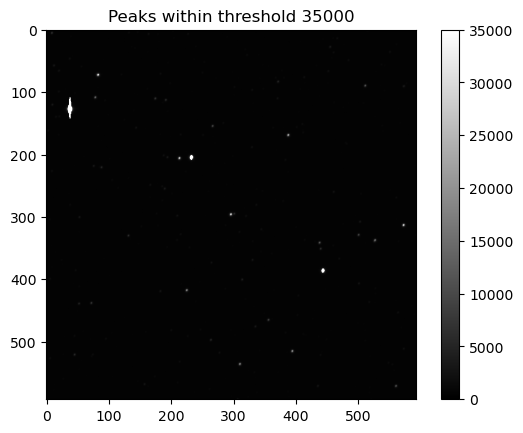

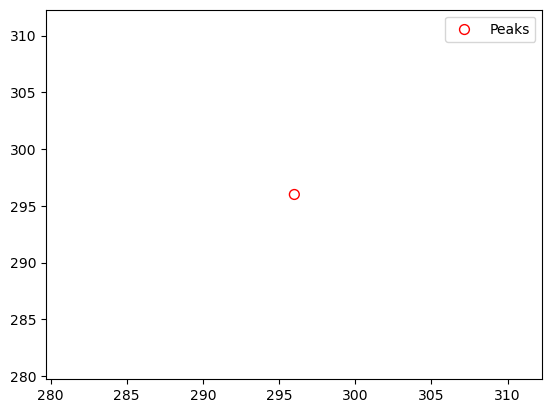

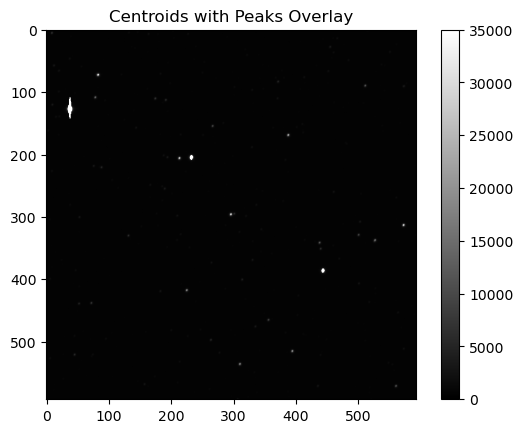

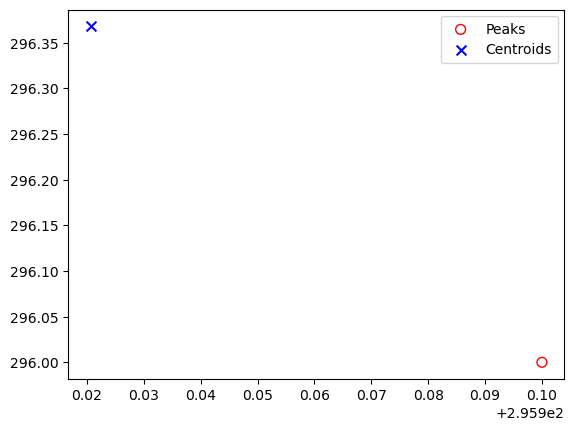

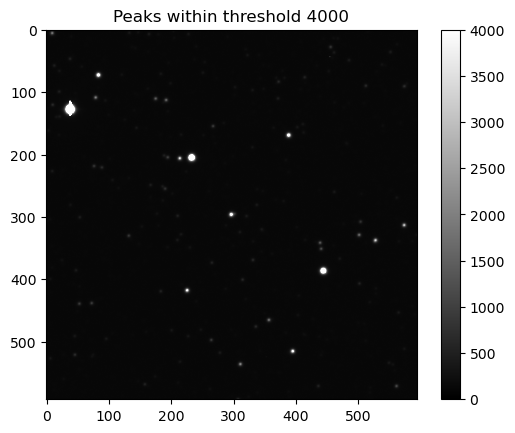

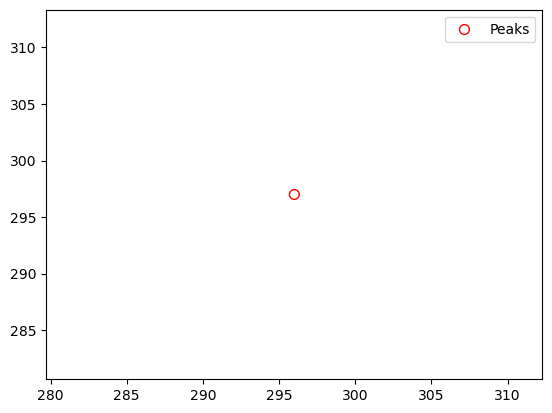

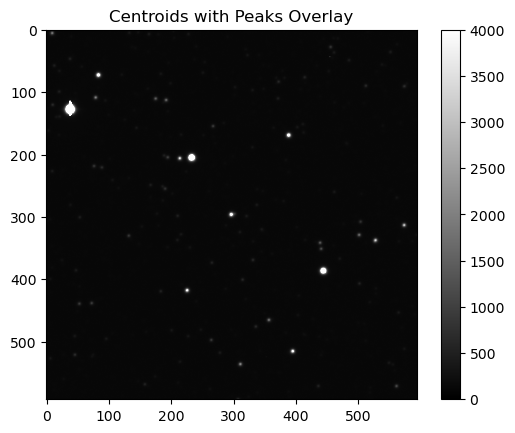

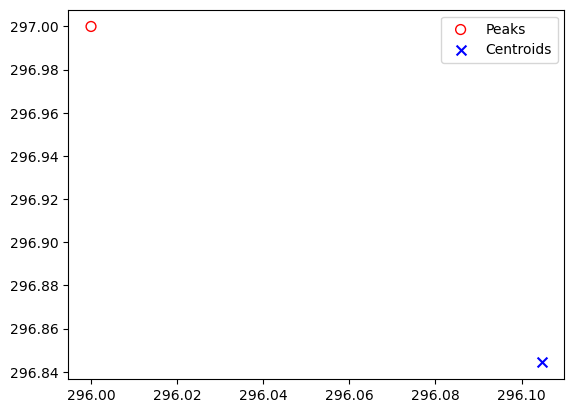

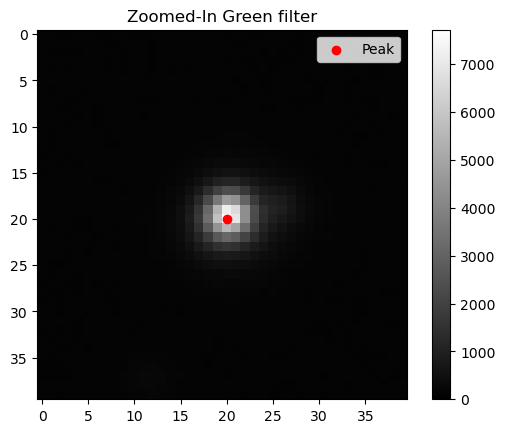

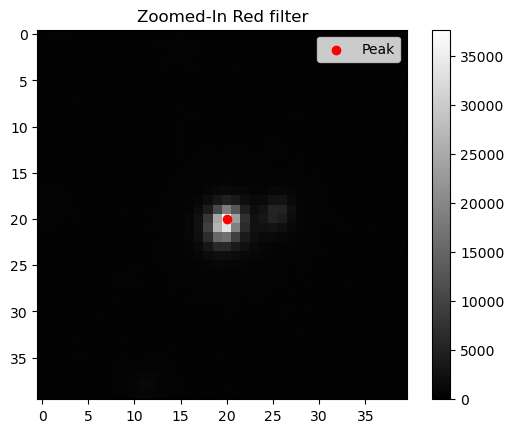

Green Science Star Instrumental Magnitude: [-9.65625058697297]
Red Science Star Instrumental Magnitude: [-10.618005249350894]


In [186]:
science_file_red = "C:/Users/ryewa/OneDrive/Desktop/AAAA/ztf_20180408131644_000743_zr_c10_o_q4_sciimg_ra74.5043_dec48.3010_asec599.fits"
threshold_red = 35000

data_red, header_red = load_fits(science_file_red)
peaks_red = find_peaks(data_red, threshold_red, target=(300, 300), radius=10)
plot_peaks(data_red, peaks_red, threshold_red)
centroids_red = [find_centroid(data_red, x, y) for x, y in peaks_red]
plot_centroid(data_red, peaks_red, centroids_red, threshold_red)


science_file_green = "C:/Users/ryewa/OneDrive/Desktop/AAAA/ztf_20180408192384_000743_zg_c10_o_q4_sciimg_ra74.5043_dec48.3010_asec599.fits"
threshold_green = 4000

data_green, header_green = load_fits(science_file_green)
peaks_green = find_peaks(data_green, threshold_green, target=(300, 300), radius=10)
plot_peaks(data_green, peaks_green, threshold_green)
centroids_green = [find_centroid(data_green, x, y) for x, y in peaks_green]
plot_centroid(data_green, peaks_green, centroids_green, threshold_green)

green_standards = ["C:/Users/ryewa/OneDrive/Desktop/Greens/ztf_20180816344606_000734_zg_c06_o_q4_sciimg_ra348.4118_dec39.4174_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Greens/ztf_20180822376991_000498_zg_c04_o_q4_sciimg_ra355.6520_dec1.0997_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Greens/ztf_20180822400278_000693_zg_c10_o_q3_sciimg_ra353.6506_dec34.0395_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Greens/ztf_20180904310255_000548_zg_c06_o_q2_sciimg_ra348.0901_dec10.7845_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Greens/ztf_20180929304352_000498_zg_c04_o_q4_sciimg_ra356.0641_dec1.2368_asec599.fits"]

red_standards = ["C:/Users/ryewa/OneDrive/Desktop/Reds/ztf_20180823319317_001734_zr_c03_o_q2_sciimg_ra353.6506_dec34.0395_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Reds/ztf_20180823362465_001492_zr_c12_o_q3_sciimg_ra355.6520_dec1.0997_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Reds/ztf_20180903327755_001543_zr_c15_o_q4_sciimg_ra348.0901_dec10.7845_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Reds/ztf_20180903335035_000498_zr_c04_o_q4_sciimg_ra356.0641_dec1.2368_asec599.fits",
"C:/Users/ryewa/OneDrive/Desktop/Reds/ztf_20180815387153_000734_zr_c06_o_q4_sciimg_ra348.4118_dec39.4174_asec599.fits"
  ]

plot_zoomed_in_star(data_green, peaks_green, star_label="Green filter", zoom_radius=20)
plot_zoomed_in_star(data_red, peaks_red, star_label="Red filter", zoom_radius=20)


green_instrumental_mag = process_standards([science_file_green], threshold_green)
red_instrumental_mag = process_standards([science_file_red], threshold_red)
print("Green Science Star Instrumental Magnitude:", green_instrumental_mag)
print("Red Science Star Instrumental Magnitude:", red_instrumental_mag)


Green Science Star Instrumental Magnitude: [-9.65625058697297]
Red Science Star Instrumental Magnitude: [-10.618005249350894]


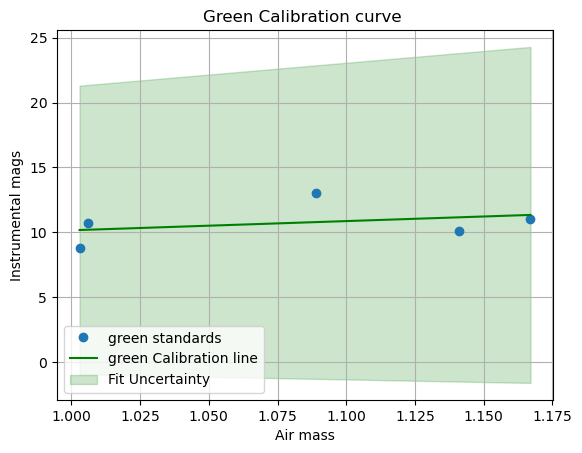

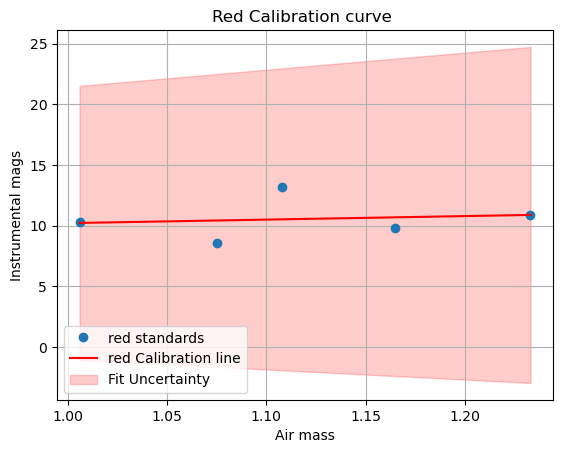

In [187]:
standard_magnitudes_red = [9.8, 10.87, 13.2, 8.6, 10.3] 
air_masses_red = [1.165, 1.233, 1.108, 1.075, 1.006]

standard_magnitudes_green = [10.12, 11.04, 13.04, 8.8, 10.7] 
air_masses_green = [1.141, 1.167,1.089, 1.003, 1.006]

green_instrumental_mag = process_standards([science_file_green], threshold_green)
red_instrumental_mag = process_standards([science_file_red], threshold_red)
print("Green Science Star Instrumental Magnitude:", green_instrumental_mag)
print("Red Science Star Instrumental Magnitude:", red_instrumental_mag)
plot_calibration_curve(air_masses_green, standard_magnitudes_green, color='green')
plot_calibration_curve(air_masses_red, standard_magnitudes_red, color='red')

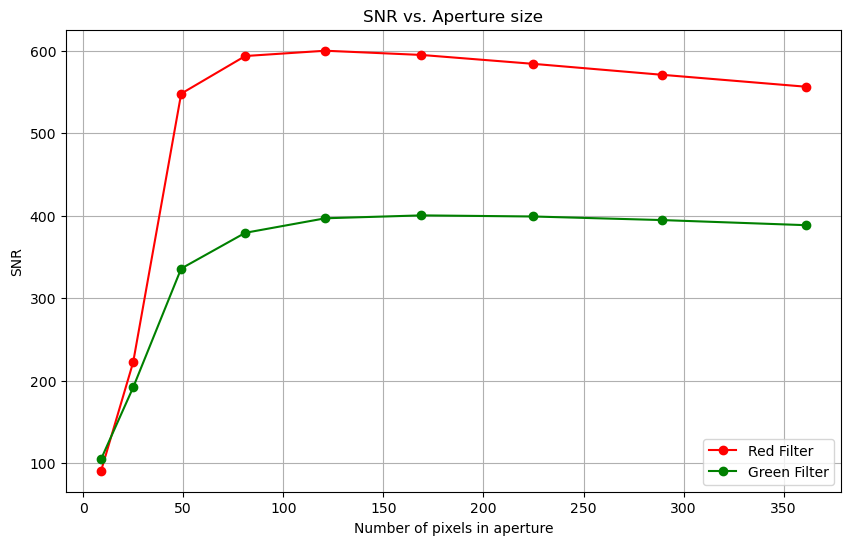

In [188]:
peak_x, peak_y = 300, 300  # Approximate 

# Plot growth curves for both 
plt.figure(figsize=(10, 6))
generate_growth_curve(data_red, peak_x, peak_y, max_aperture=20, sigma_x=1, sigma_y=1, color='red', label='Red Filter')
generate_growth_curve(data_green, peak_x, peak_y, max_aperture=20, sigma_x=1, sigma_y=1, color='green', label='Green Filter')
plt.show()

In [223]:
def process_standards_with_indices(standard_files, threshold, target=(300, 300), radius=10, exposure_time=30):
    instrumental_magnitudes = []
    valid_indices = []
    for idx, filename in enumerate(standard_files):
        data, header = load_fits(filename)
        peaks = find_peaks(data, threshold, target=target, radius=radius)
        if len(peaks) == 0:
            peaks = find_peaks(data, threshold * 0.9, target=target, radius=radius)
        if len(peaks) == 0:
            continue
        centroids = [find_centroid(data, x, y) for x, y in peaks]
        if len(centroids) == 0:
            continue
        centroid_x, centroid_y = centroids[0]
        N_net, snr = calculate_signal_to_noise(data, centroid_x, centroid_y, sigma_x=1, sigma_y=1, aperture=120)
        instrumental_mag = calculate_instrumental_magnitude(N_net, exposure_time)
        instrumental_magnitudes.append(instrumental_mag)
        valid_indices.append(idx)
    return instrumental_magnitudes, valid_indices

def calibrate_filter(standard_files, threshold, standard_magnitudes, air_masses, science_instrumental_mag, air_mass_science, color="filter"):
    instrumental_mags, valid_indices = process_standards_with_indices(standard_files, threshold)
    filtered_standard_magnitudes = [standard_magnitudes[i] for i in valid_indices]
    filtered_air_masses = [air_masses[i] for i in valid_indices]
    if len(filtered_standard_magnitudes) >= 2:
        zp, k, _ = calibrate_instrumental_magnitudes(filtered_standard_magnitudes, instrumental_mags, filtered_air_masses)
        
        real_magnitude = calculate_real_magnitude(science_instrumental_mag, zp, k, air_mass_science)
        
        return real_magnitude
    else:
        return None


# Red filter
air_mass_science_red = 1.1 

red_real_magnitude = calibrate_filter(
    red_standards, threshold_red, standard_magnitudes_red, air_masses_red, red_science_mag, air_mass_science_red, color="red"
)

# Green filter 
air_mass_science_green = 1.1 

green_real_magnitude = calibrate_filter(
    green_standards, threshold_green, standard_magnitudes_green, air_masses_green, green_science_mag, air_mass_science_green, color="green"
)

print("Red filter mag of science star:", red_real_magnitude)
print("Green filter mag of science star:", green_real_magnitude)


Red filter mag of science star: 11.665744121362023
Green filter mag of science star: 12.69656071217019
